## Imports

In [1]:
import pyxdf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

## Function Definitions

Predicted pupil dilation, $d(Y)$, caused by luminance $Y$, is computed with the following equation: $𝑑(𝑌) = 𝑎 · 𝑒^{−𝑏·𝑌} + c$

In [2]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

## Load Data

Load the data from the experimental input files for a single participant.

In [3]:
streams, header = pyxdf.load_xdf('./Path_Data/ID_109.xdf')

dfs = {}
for stream in streams:
    stream_name = stream['info']['name'][0]
    stream_channels = {}
    for i, channels in enumerate(stream['info']['desc'][0]['channels'][0]['channel']):
        stream_channels[channels['label'][0]] = i
    stream_data = stream['time_series']
    #example of data layout
    #stream_name: LuminanceStream
    #stream_channels: {'UserID': 0, 'BlockID': 1, 'ModelID': 2, 'MethodID': 3, 'Luminance': 4}
    #stream_data: [[1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02][1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02][1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02]
    data_dict= {}
    for key in stream_channels.keys():
        data_dict[key] = np.array(stream_data)[:, stream_channels[key]]
    time_stamps = np.array(stream['time_stamps'])
    for i in range(len(time_stamps)):
        time_stamps[i] = round(time_stamps[i], 4)
    data_dict['time'] = time_stamps
    dfs[stream_name] = pd.DataFrame(data_dict)
    dfs[stream_name].drop_duplicates(subset=['time'], keep='first', inplace=True)
    dfs[stream_name].reset_index(drop=True, inplace=True)

In [7]:
gaze = dfs['GazeStream']
luminance = dfs['LuminanceStream']
stimulus_events = dfs['ExperimentStream']

calibration_events = stimulus_events.loc[(stimulus_events['EventType'] == 'CalibrationColorChange') | (stimulus_events['SceneEvent'] == 'Calibration'), ['time','SceneEvent', 'EventType']]
calibration_events.reset_index(drop=True, inplace=True)
start_time = calibration_events.loc[0, 'time']

pupil_calib_d = gaze.loc[(gaze['MethodID']>98.0) & (gaze['LeftEyeIsBlinking']==0) & (gaze['RightEyeIsBlinking']==0) & (gaze['LeftPupilDiameter']>0) & (gaze['RightPupilDiameter']>0), ['time', 'LeftPupilDiameter', 'RightPupilDiameter']]
pupil_calib_d.reset_index(drop=True, inplace=True)
lum_calib = luminance.loc[(luminance['MethodID']>98.0), ['time', 'Luminance']]
lum_calib.reset_index(drop=True, inplace=True)
gaze_luminance_time = np.intersect1d(pupil_calib_d['time'], lum_calib['time'])
pupil_calib_d = pupil_calib_d[pupil_calib_d['time'].isin(gaze_luminance_time)]
lum_calib = lum_calib[lum_calib['time'].isin(gaze_luminance_time)]
pupil_calib_d.reset_index(drop=True, inplace=True)
lum_calib.reset_index(drop=True, inplace=True)
print(luminance)


In [8]:
luminance_pupil_diameter = pd.DataFrame()
luminance_pupil_diameter['time'] = pd.to_timedelta(lum_calib['time'] - start_time, unit='s')
luminance_pupil_diameter['Luminance'] = lum_calib['Luminance']
luminance_pupil_diameter['pupilDiameter'] = 0.5 * (pupil_calib_d['LeftPupilDiameter'] + pupil_calib_d['RightPupilDiameter'])
luminance_pupil_diameter = luminance_pupil_diameter.resample('0.5s', on='time').mean()
luminance_pupil_diameter['time'] = luminance_pupil_diameter.index
luminance_pupil_diameter.reset_index(drop=True, inplace=True)
print(luminance_pupil_diameter)

    Luminance  pupilDiameter                   time
0    0.205574       4.059823 0 days 00:00:01.674400
1    0.205574       2.895248 0 days 00:00:02.174400
2    0.205574       2.816653 0 days 00:00:02.674400
3    0.205574       2.831728 0 days 00:00:03.174400
4    0.205574       2.848754 0 days 00:00:03.674400
..        ...            ...                    ...
88   0.369418       2.776748 0 days 00:00:45.674400
89   0.369418       2.744246 0 days 00:00:46.174400
90   0.369418       2.734839 0 days 00:00:46.674400
91   0.369418       2.700307 0 days 00:00:47.174400
92   0.369418       2.627306 0 days 00:00:47.674400

[93 rows x 3 columns]


In [ ]:
#for luminance_pupil_diameter['time'][x] = 

In [37]:
#𝑎, 𝑏, and 𝑐 were fitted using least squares optimization with empirically determined bounds of a: [1, 4], b: [4, 8], and c: [0, 8]
x_data = luminance_pupil_diameter['Luminance']
y_data = luminance_pupil_diameter['pupilDiameter']

popt_l, pcov_l = curve_fit(func, x_data, y_data, bounds=([1, 4, 0], [4, 8, 8]))

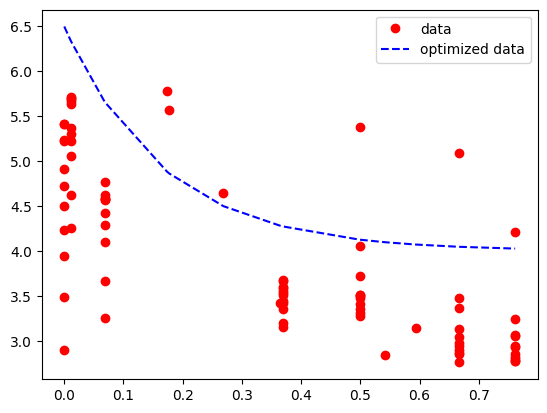

In [38]:
ans = func(x_data, *popt_l)

plt.plot(x_data, y_data, 'o', color ='red', label ="data")
plt.plot(x_data, ans, '--', color ='blue', label ="optimized data")
plt.legend()
plt.show()